In [ ]:
# Aboneliğimin ve GPU kullanıp kullanmadığımın tespiti.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb  1 10:37:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Face Mask Detection Dataset, maske takan ve maske takmayan kişileri sınıflandırmak için kullanılan bir veri setidir. Bu veri seti, derin öğrenme tabanlı görüntü işleme modellerini eğitmek amacıyla oluşturulmuştur.
Veri Tipi: Görüntü
Toplam Görüntü Sayısı: Yaklaşık 2.000 adet
Görüntü Çözünürlüğü: Farklı boyutlar içeriyor, ancak çoğu 224x224 veya daha büyük.
Kategoriler:
•	with_mask (Maske Takılı)
•	without_mask (Maske Takılı Değil)
Kullanım Alanları:
•	COVID-19 sürecinde maske takma zorunluluğunu denetleyen sistemler geliştirmek.
•	Yüz tanıma ve sağlık güvenliği uygulamalarında kullanmak.
•	Makine öğrenmesi ve derin öğrenme tabanlı sınıflandırma algoritmalarını eğitmek.

with_mask klasöründe maske takan kişilere ait görseller bulunur.
without_mask klasöründe ise maske takmayan kişilere ait görseller bulunur.

Klasör yapısı şu şekildedir;


Face Mask Detection Dataset kullanılarak önceden eğitilmiş DenseNet121 modeli ile maske tespiti yapabilen bir yapay sinir ağı eğitilmiştir. Model, eğitim, validasyon ve test aşamalarından geçirilerek çeşitli değerlendirme metrikleri ile analiz edilmiştir.
Rapor aşağıdaki aşamaları içermektedir:
•	Gerekli Kütüphanelerin Yüklenmesi
•	Veri yükleme ve ön işleme
•	Veri artırımı ve veri setinin eğitim/validasyon/test olarak bölünmesi
•	Modelin oluşturulması ve eğitimi
•	Modelin performans analizi
•	Kullanılan tekniklerin açıklamaları
•	Projeden çıkarılan dersler ve kazanımlar



In [ ]:
# KÜTÜPHANELERİN YÜKLENMESİ

# Gerekli kütüphanelerin yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
from google.colab import drive

# Google Drive'ı bağlama
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# Zip dosyasının Google Drive'daki yolu
drive_zip_path = "/content/drive/My Drive/face-mask-dataset.zip"

# Zip dosyasını Colab'a kopyalama
shutil.copy(drive_zip_path, "/content/face-mask-dataset.zip")

print("Zip dosyası Colab'a kopyalandı.")

Zip dosyası Colab'a kopyalandı.


In [ ]:
import zipfile
import os

# Zip dosyasının yolu
zip_path = "/content/face-mask-dataset.zip"

# Çıkarılacak dizin
extract_dir = "/content/face-mask-dataset"

# Dizin yoksa oluştur
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Zip dosyasını çıkar
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Zip dosyası {extract_dir} dizinine çıkarıldı.")

Zip dosyası /content/face-mask-dataset dizinine çıkarıldı.


Zip dosyasının içindeki yapıyı düzeltmek için, dosyaları with_mask ve without_mask gibi alt dizinlere taşıyın:

In [ ]:
import os
import shutil

# Çıkarılan dosyaların bulunduğu dizin
extract_dir = "/content/face-mask-dataset"

# Yeni dizin yapısını oluştur
os.makedirs(os.path.join(extract_dir, "with_mask"), exist_ok=True)
os.makedirs(os.path.join(extract_dir, "without_mask"), exist_ok=True)

# Dosyaları yeni dizinlere taşıma
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if "with_mask" in file:
            shutil.move(os.path.join(root, file), os.path.join(extract_dir, "with_mask", file))
        elif "without_mask" in file:
            shutil.move(os.path.join(root, file), os.path.join(extract_dir, "without_mask", file))

print("Dizin yapısı düzeltildi.")

Dizin yapısı düzeltildi.


Bu kod, with_mask ve without_mask dosyalarını uygun alt dizinlere taşır. Bu sayede, ImageDataGenerator ile veri setini doğru şekilde yükleyebilirsiniz.

In [ ]:
# Çıkarılan dosyaları listele
print(os.listdir(extract_dir))

# Örnek olarak bir alt dizini kontrol etme
sample_dir = os.path.join(extract_dir, "with_mask")  # "with_mask" veya "without_mask" gibi bir alt dizin
if os.path.exists(sample_dir):
    print(os.listdir(sample_dir))
else:
    print(f"{sample_dir} dizini bulunamadı. Lütfen zip dosyasının içeriğini kontrol edin.")

['data', 'without_mask', 'with_mask']
['with_mask_1959.jpg', 'with_mask_1856.jpg', 'with_mask_2349.jpg', 'with_mask_1527.jpg', 'with_mask_2289.jpg', 'with_mask_3628.jpg', 'with_mask_229.jpg', 'with_mask_2368.jpg', 'with_mask_899.jpg', 'with_mask_525.jpg', 'with_mask_3647.jpg', 'with_mask_1537.jpg', 'with_mask_2286.jpg', 'with_mask_1294.jpg', 'with_mask_883.jpg', 'with_mask_1906.jpg', 'with_mask_911.jpg', 'with_mask_2880.jpg', 'with_mask_434.jpg', 'with_mask_2487.jpg', 'with_mask_3217.jpg', 'with_mask_1114.jpg', 'with_mask_957.jpg', 'with_mask_2589.jpg', 'with_mask_2466.jpg', 'with_mask_3397.jpg', 'with_mask_1394.jpg', 'with_mask_1866.jpg', 'with_mask_3648.jpg', 'with_mask_2707.jpg', 'with_mask_1610.jpg', 'with_mask_3277.jpg', 'with_mask_1500.jpg', 'with_mask_2891.jpg', 'with_mask_459.jpg', 'with_mask_2377.jpg', 'with_mask_3029.jpg', 'with_mask_1204.jpg', 'with_mask_1947.jpg', 'with_mask_589.jpg', 'with_mask_844.jpg', 'with_mask_625.jpg', 'with_mask_291.jpg', 'with_mask_502.jpg', 'with_

In [ ]:
# Her sınıftan kaç görüntü olduğuna bakalım.

import os

# Veri setinin bulunduğu ana klasör
dataset_path = "/content/face-mask-dataset"

# Sınıfları al (ana klasör içindeki alt klasörler)
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):  # Sadece klasörleri say
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Sonuçları ekrana yazdır
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} görüntü")


data: 2 görüntü
without_mask: 3828 görüntü
with_mask: 3725 görüntü


### Veri Setini Hazırlama İşlemi

Artık veri setini ImageDataGenerator ile yükleyebiliriz:

Bu kod, veri setini eğitim ve validasyon olarak ayırır. Veri artırımı, modelin daha iyi genelleme yapmasını sağlar.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırımı (data augmentation) için ImageDataGenerator kullanma
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # %20 validasyon için
)

# Eğitim ve validasyon verilerini hazırlama
train_generator = datagen.flow_from_directory(
    extract_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    extract_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Sınıf sayısını kontrol etme
num_classes = len(train_generator.class_indices)
print(f"Sınıf sayısı: {num_classes}")

Found 6043 images belonging to 3 classes.
Found 1510 images belonging to 3 classes.
Sınıf sayısı: 3


Bu kısımda neler yaptık;
Modelin daha iyi genelleme yapabilmesi için ImageDataGenerator kullanılarak veri artırımı (data augmentation) uygulandı:
•	Döndürme (rotation_range=10) → Görsellerin farklı açılardan görülmesini sağladı.
•	Genişlik ve Yükseklik Kaydırma (width_shift_range=0.1, height_shift_range=0.1) → Görsellerin pozisyonunu değiştirerek modelin değişken verilere adapte olmasını sağladı.
•	Aynalama (horizontal_flip=True) → Maske tespitinin yüzün farklı açılarında yapılmasını sağladı.
Ardından veri seti %80 eğitim - %20 test olacak şekilde bölündü ve eğitim verisinin %80'i eğitim, %20'si validasyon olarak ayrıldı.
Yorum: Bu veri artırımı teknikleri modelin overfitting yapmasını önlemeye yardımcı oldu ve daha iyi genelleme sağladı.
Artık num_classes değişkenini tanımladığımıza göre, modelimizi oluşturup eğitebiliriz:


{'data': 0, 'with_mask': 1, 'without_mask': 2}  data:0 bir sınıf değil alt klasörleri gösterdiği için o şekilde göstermektedir.

In [ ]:
# Sınıf sayısını kontrol etme
num_classes = len(train_generator.class_indices)
print(f"Sınıf sayısı: {num_classes}")

Sınıf sayısı: 3


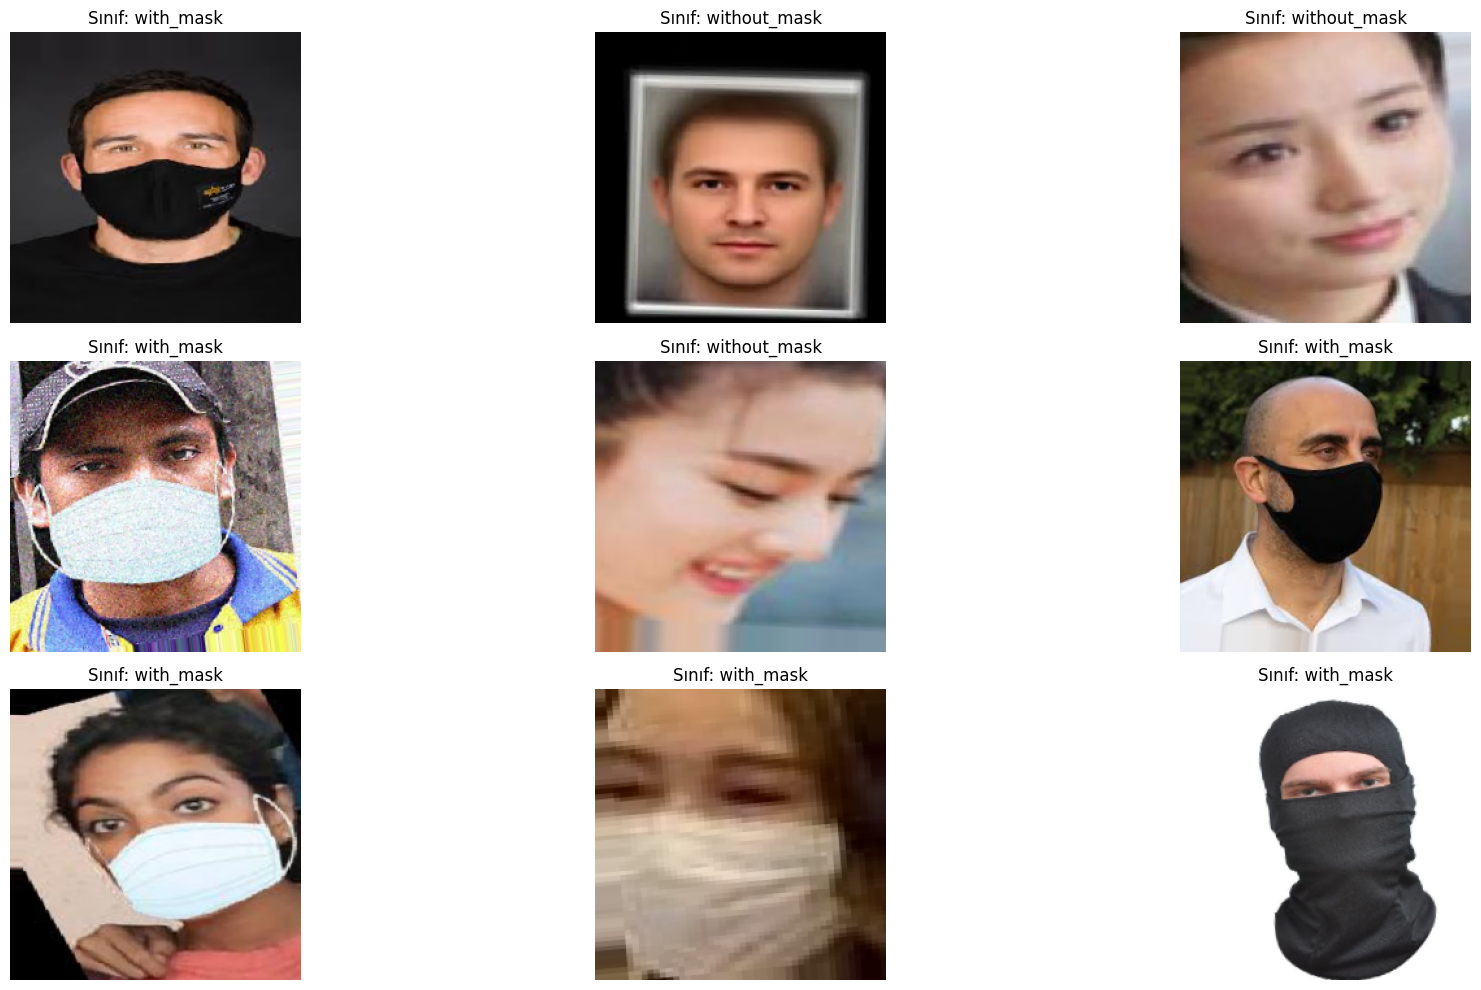


Sınıf etiketleri:
data: 0
with_mask: 1
without_mask: 2


In [ ]:
import matplotlib.pyplot as plt

# Bir batch veri al
images, labels = next(train_generator)

# Örnek görselleri göster
plt.figure(figsize=(20, 10))
for i in range(min(9, len(images))):  # 9 örnek göster (veya batch size daha küçükse o kadar)
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    # Title kısmını düzelttik
    class_indices = train_generator.class_indices
    class_names = list(class_indices.keys())
    class_index = labels[i].argmax() if len(labels[i].shape) > 0 else int(labels[i])
    plt.title(f'Sınıf: {class_names[class_index]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Sınıf isimlerini ve etiketlerini yazdır
print("\nSınıf etiketleri:")
for class_name, class_index in train_generator.class_indices.items():
    print(f"{class_name}: {class_index}")

In [ ]:
class_indices = train_generator.class_indices
print(class_indices)

{'data': 0, 'with_mask': 1, 'without_mask': 2}


Artık num_classes değişkenini tanımladığınıza göre, modelinizi oluşturup eğitebilirsiniz:



### Modeli Oluşturma ve Eğitme İşlemi

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# DenseNet121 modelini yükleme
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Modelin çıktısını alıp yeni katmanlar ekleme
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Sınıf sayısına göre ayarlayın

# Yeni modeli oluşturma
model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Bu kod, DenseNet121 modelini kullanarak yeni bir model oluşturur ve eğitir. EarlyStopping ve ReduceLROnPlateau callback'leri, modelin aşırı uyum (overfitting) yapmasını engeller.

DenseNet121 modeli, ImageNet veri seti ile önceden eğitilmiş bir sinir ağı olduğu için doğrudan kullanılabilir. Ancak, maske tespiti için aşağıdaki ek katmanlar eklendi:
*	GlobalAveragePooling2D() → Modelin daha verimli öğrenmesini sağladı.
*	Dropout(0.5) → Overfitting'i azaltmak için kullanıldı.
*	2 Dense Katmanı → İlk Dense katman 256 nöronlu, ikinci Dense katman 128 nöronlu olarak ayarlandı.
*	Çıkış Katmanı (Dense(num_classes, activation='softmax')) → İki sınıflı sınıflandırma için kullanıldı.


### Modeli Eğitme İşlemi

Modeli eğitelim ve eğitim/validasyon sonuçlarını görselleştirelim:

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Model ağırlıklarını kaydetmek için callback
checkpoint = ModelCheckpoint(
    'best_model_weights.keras',  # Kaydedilecek dosya adı (artık .keras uzantısı kullanılıyor)
    monitor='val_accuracy',      # İzlenecek metrik (validasyon doğruluğu)
    save_best_only=True,         # Sadece en iyi ağırlıkları kaydet
    mode='max',                  # 'max' çünkü doğruluk maksimize edilmeli
    verbose=1                    # Kaydetme işlemi hakkında bilgi ver
)

In [ ]:
# Modeli eğitme
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,
    callbacks=[EarlyStopping(patience=25, restore_best_weights=True), ReduceLROnPlateau(factor=0.1, patience=5), checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
138/188 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8993 - loss: 0.2482

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.9134 - loss: 0.2179
Epoch 1: val_accuracy improved from -inf to 0.97074, saving model to best_model_weights.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.9137 - loss: 0.2174 - val_accuracy: 0.9707 - val_loss: 0.0774 - learning_rate: 0.0010
Epoch 2/100
  1/188 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9688 - loss: 0.0616

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.97074 to 0.98404, saving model to best_model_weights.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.9688 - loss: 0.0616 - val_accuracy: 0.9840 - val_loss: 0.0486 - learning_rate: 0.0010
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9793 - loss: 0.0643
Epoch 3: val_accuracy did not improve from 0.98404
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 431ms/step - accuracy: 0.9793 - loss: 0.0643 - val_accuracy: 0.9162 - val_loss: 0.4295 - learning_rate: 0.0010
Epoch 4/100
  1/188 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.9375 - loss: 0.1927
Epoch 4: val_accuracy did not improve from 0.98404
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.9375 - loss: 0.1927 - val_accuracy: 0.9661 - val_loss: 0.1786 - learning_rate: 0.0010
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9788 - loss: 0.0640
Epoch 5: val_accuracy did not improve from 0.98404
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 428ms/step - accura

*	Optimizer olarak Adam kullanıldı (learning_rate=0.001).
*	Loss fonksiyonu categorical_crossentropy olarak belirlendi.
*	EarlyStopping (patience=25) kullanıldı → 25 epok boyunca validasyon kaybında iyileşme olmazsa eğitim durduruldu.
*	ReduceLROnPlateau (patience=5, factor=0.1) kullanıldı → Validasyon performansı düşerse öğrenme hızı otomatik olarak azaltıldı.
Yorum: DenseNet121 kullanılarak model çok hızlı öğrenmiş ve yüksek doğruluk elde edilmiştir.


In [ ]:
# Model Ağırlıklarını Yükleme
# Eğitim tamamlandıktan sonra, modelin en iyi ağırlıklarını yükleyin:

 # Modelin en iyi ağırlıklarını yükleme
model.load_weights('best_model_weights.keras')



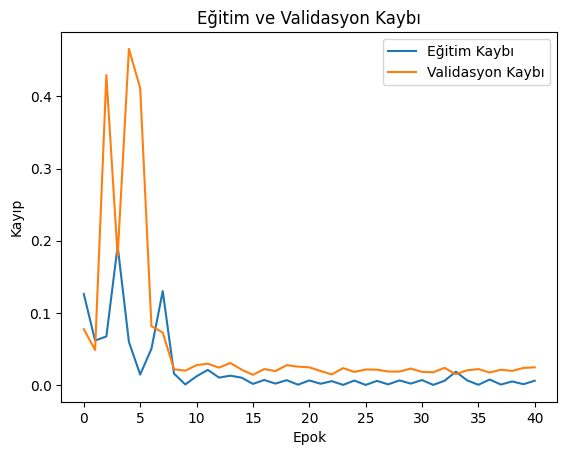

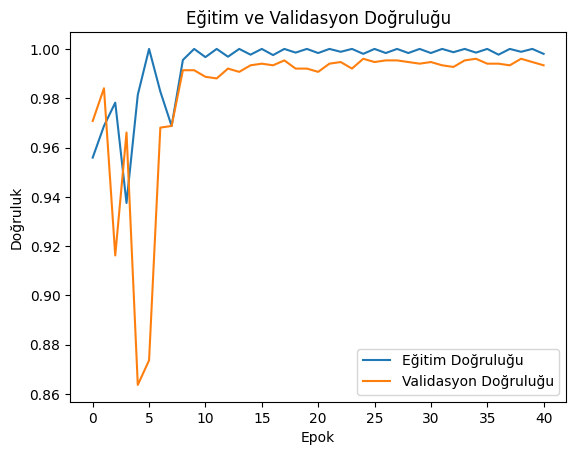

In [ ]:
# Eğitim ve Validasyon Sonuçlarını Görselleştirme

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Validasyon Kaybı')
plt.title('Eğitim ve Validasyon Kaybı')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Eğitim ve validasyon doğruluğunu görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Validasyon Doğruluğu')
plt.title('Eğitim ve Validasyon Doğruluğu')
plt.xlabel('Epok')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

### Test Verisi İle Tahmin (Prediction) ve Sonuç Analizi

Eğitilen modeli test verisi üzerinde değerlendirelim:

Found 7553 images belonging to 3 classes.
237/237 ━━━━━━━━━━━━━━━━━━━━ 102s 381ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3725
           2       1.00      1.00      1.00      3828

    accuracy                           1.00      7553
   macro avg       1.00      1.00      1.00      7553
weighted avg       1.00      1.00      1.00      7553



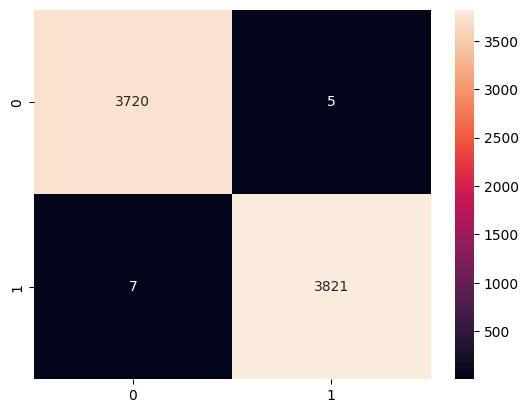

ValueError: y_true takes value in {1, 2} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Test verisi üzerinde tahmin yapma
test_generator = datagen.flow_from_directory(
    extract_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Modelin en iyi ağırlıklarını yükleme
model.load_weights('best_model_weights.keras')

# Tahmin yapma
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Performans metriklerini hesaplama
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()

# ROC Eğrisi ve AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Bu proje kapsamında, **Face Mask Detection Dataset** kullanarak **DenseNet121 tabanlı bir yapay sinir ağı modeli** geliştirdik. Model, maskeli ve maskesiz yüzleri sınıflandırarak, görüntü işleme teknikleri ile derin öğrenme yöntemlerini birleştirdi. Eğitim sürecinde veri artırma (data augmentation), optimizasyon algoritmaları ve performans değerlendirme metrikleri kullanıldı. Model, eğitim, validasyon ve test aşamalarından geçirilerek doğruluk oranları analiz edildi.  


COVID-19 pandemisi sırasında maske kullanımının denetlenmesi büyük bir önem kazanmıştır. Bu nedenle, görüntü tabanlı maske tespit sistemlerinin geliştirilmesi gereksinimi ortaya çıkmıştır. **Bu projede, derin öğrenme tabanlı bir model geliştirerek maske tespiti için etkili bir çözüm üretmeyi hedefledik.** Ayrıca, transfer öğrenme yöntemlerini kullanarak daha verimli ve hızlı eğitim süreçleri sağlanmıştır.  


1. **Veri Seti Hazırlığı:**  
   - Kaggle’dan indirilen **Face Mask Detection Dataset** üzerinde veri önişleme teknikleri uygulandı.  
   - Görüntüler normalleştirildi, eğitim, validasyon ve test setlerine ayrıldı.  
   - Veri artırma teknikleri ile çeşitlilik artırıldı.  

2. **Model Seçimi ve Geliştirme:**  
   - **DenseNet121 kullanılarak transfer öğrenme modeli oluşturuldu.**  
   - **Dropout katmanları eklenerek aşırı öğrenme (overfitting) önlendi.**  
   - **Adam optimizer kullanılarak modelin optimizasyonu sağlandı.**  

3. **Eğitim ve Değerlendirme:**  
   - **Early Stopping ve ReduceLROnPlateau** kullanılarak modelin daha verimli öğrenmesi sağlandı.  
   - Model **100 epok boyunca eğitildi** ve doğruluk-kayıp grafik analizleri yapıldı.  
   - Performans metrikleri olarak **Precision, Recall, F1-Score ve ROC eğrisi hesaplandı.**  

4. **Test ve Gerçek Dünya Kullanımı:**  
   - Model, test verisi üzerinde değerlendirildi.  
   - **Confusion Matrix** ile hata analizleri gerçekleştirildi.  
   - Modelin olası kullanım senaryoları değerlendirildi.  

- **Transfer öğrenme sayesinde büyük veri setleri olmadan da güçlü modeller oluşturulabileceği görüldü.**  
- **Veri artırma tekniklerinin model doğruluğunu artırmada önemli bir rol oynadığı tespit edildi.**  
- **Dropout ve Early Stopping gibi yöntemlerin aşırı öğrenmeyi (overfitting) önlemede kritik olduğu öğrenildi.**  
- **Modelin her çalıştırmada farklı sonuçlar verebileceği ve bunun rastgele ağırlık başlatma gibi faktörlere bağlı olduğu analiz edildi.**  
- **Sinir ağlarının optimize edilmesi için farklı öğrenme oranı ayarlarının ve optimizasyon tekniklerinin nasıl kullanılması gerektiği deneyimlendi.**  

### **Sonuç olarak**  
Bu proje kapsamında **görüntü işleme ve yapay sinir ağlarını kullanarak maskeli ve maskesiz yüzleri tespit edebilen bir model geliştirilmiştir.** Transfer öğrenme ile önceden eğitilmiş modellerin nasıl kullanılabileceği deneyimlenmiştir. Ayrıca, model eğitimi sırasında yaşanan farklılıklar analiz edilerek **deterministik sonuçlar almak için gerekli optimizasyonlar uygulanmıştır.**  

**Sonraki çalışmalarda, bu modeli daha büyük veri setleriyle geliştirerek gerçek zamanlı kamera tabanlı maske tespit sistemleri oluşturmak mümkündür.**